 Network compression for mnist model

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
import warnings
warnings.filterwarnings('ignore')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
n_hiddenlayer = 5
n_hiddenunits = 1024
n_classes = 10
n_inpsize = 784
batch_size = 128

Xinp = tf.placeholder('float',[None,n_inpsize])
y = tf.placeholder('float')
is_training = tf.placeholder(tf.bool)

last = []

Below the fully connected model with no queantization is made

In [0]:
def FC_graph(data):
  init = tf.contrib.layers.variance_scaling_initializer(uniform=True,factor=1.0)
  
  layer1 = tf.layers.dense(inputs=data, units=1024, activation=tf.nn.relu,name='layer1')#,kernel_initializer=init,bias_initializer=init)
  #dropout1 = tf.layers.dropout(inputs=layer1, rate=0.3,training=is_training)
  layer2 = tf.layers.dense(inputs=layer1, units=1024, activation=tf.nn.relu,name='layer2')#,kernel_initializer=init,bias_initializer=init)
  layer3 = tf.layers.dense(inputs=layer2, units=1024, activation=tf.nn.relu,name='layer3')#,kernel_initializer=init,bias_initializer=init)
  #dropout2 = tf.layers.dropout(inputs=layer3, rate=0.3,training=is_training)
  layer4 = tf.layers.dense(inputs=layer3, units=1024, activation=tf.nn.relu,name='layer4')#,kernel_initializer=init,bias_initializer=init)
  layer5 = tf.layers.dense(inputs=layer4, units=1024, activation=tf.nn.relu,name='layer5')#,kernel_initializer=init,bias_initializer=init)
  out = tf.layers.dense(inputs=layer5, units=10, activation=None,name='out')
  return out


For the quantization we are using SVD to get shorter versions of weight matrix but now we have two of them in form of U and V. So to incorporate this as in 1.6a, I have used subclass for dense layer to have U and V as its variables.

In [0]:
def actnone(x):
  return x
class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, input, num_outputs,activation=actnone,Uinit= None, Vinit =None, biasinit= None):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs
    self.activation= activation 
    print(self.activation)
    self.U = self.add_variable("U", shape=[int(input.shape[-1]), int(input.shape[-1])])
    self.V = self.add_variable("V", shape=[int(input.shape[-1]), self.num_outputs])
    init = tf.contrib.layers.variance_scaling_initializer(uniform=True,factor=2.0)
    self.bias = self.add_variable("bias", shape=[self.num_outputs],dtype=tf.float32,initializer=init)#tf.zeros_initializer())
    if Uinit is not None: self.U = Uinit
    if Vinit is not None: self.V = Vinit
    
    print()
    
  def build(self ):
    pass
    
  def call(self, input):
    if self.activation is not None: return self.activation( tf.add(tf.matmul(input, self.U @ self.V), self.bias))
    return tf.add(tf.matmul(input, self.U @ self.V), self.bias)
def mod_graph(data):  
  mlayer1 = MyDenseLayer(data,1024,tf.nn.relu,Uinit=s[0][:,:20],Vinit=np.diag(u[0][:20])@v[0][:20,:])
  l1 = mlayer1.call(data)
  mlayer2 = MyDenseLayer(l1,1024,tf.nn.relu,Uinit=s[1][:,:20],Vinit=np.diag(u[1][:20])@v[1][:20,:])
  l2 = mlayer2.call(l1)
  mlayer3 = MyDenseLayer(l2,1024,tf.nn.relu,Uinit=s[2][:,:20],Vinit=np.diag(u[2][:20])@v[2][:20,:])
  l3 = mlayer3.call(l2)
  mlayer4 = MyDenseLayer(l3,1024,tf.nn.relu,Uinit=s[3][:,:20],Vinit=np.diag(u[3][:20])@v[3][:20,:])
  l4 = mlayer4.call(l3)
  mlayer5 = MyDenseLayer(l4,1024,tf.nn.relu,Uinit=s[4][:,:20],Vinit=np.diag(u[4][:20])@v[4][:20,:])
  l5 = mlayer5.call(l4)
  mout = MyDenseLayer(l5, 10, activation=None,Uinit=a[0],Vinit=np.diag(b[0])@c[0])
  #print(mlayer1(mnist.train.images))
  print(mlayer1.trainable_variables)
  return mout.call(l5)

In [0]:
weights = [[] for i in range(5)]

def train_nn(X,epochs,lr,fn="old"):
  global weights, last
  pred = FC_graph(X) if fn=="old" else mod_graph(X)
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))
  optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
  
  n_epochs = epochs
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    correct = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct,'float'))
    for epoch in range(n_epochs):
      loss = 0
      for i in range(int(mnist.train.num_examples/batch_size)):
        ex,ey = mnist.train.next_batch(batch_size)
        _,c = sess.run([optimizer,cost],feed_dict={Xinp:ex,y:ey,is_training :True})
        loss += c
      print('Epoch',epoch,' out of ',n_epochs,' loss:',loss)
      print('accuracy:',accuracy.eval({Xinp:mnist.test.images[100:200],y:mnist.test.labels[100:200],is_training :False}))
    for i in range(5):
      weights[i] = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'layer'+str(i+1)+'/kernel:0'))
    last = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'out'+'/kernel:0'))
    print(weights[1])
    #with tf.variable_scope('layer1', reuse=True):
      #tf.get_variable('weights')
    #output  = pred

    #layer = sess.run(layers[-1])
    print('accuracy:',accuracy.eval({Xinp:mnist.test.images,y:mnist.test.labels,is_training :False}))


In [0]:
train_nn(Xinp,50,0.0001)
a,b,c =  np.linalg.svd(last,full_matrices=False)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch 0  out of  50  loss: 141.63526622205973
accuracy: 0.97
Epoch 1  out of  50  loss: 46.76544467546046
accuracy: 0.99
Epoch 2  out of  50  loss: 28.42932279035449
accuracy: 0.99
Epoch 3  out of  50  loss: 18.752889033872634
accuracy: 0.99
Epoch 4  out of  50  loss: 13.369068400235847
accuracy: 0.97
Epoch 5  out of  50  loss: 8.854499636683613
accuracy: 0.98
Epoch 6  out of  50  loss: 6.062992651248351
accuracy: 0.98
Epoch 7  out of  50  loss: 5.1776374957407825
accuracy: 0.99
Epoch 8  out of  50  loss: 5.860763416363625
accuracy: 0.98
Epoch 9  out of  50  loss: 4.171576724751503
accuracy: 0.96
Epoch 10  out of  50  loss: 4.627888468829042
accuracy: 0.97
Epoch 11  out

In [0]:
s ,u,v = {},{},{}
for i in range(5):
 s[i],u[i],v[i] =  np.linalg.svd(weights[i][0],full_matrices=False)

Below the  trimmed matrices for different values of D and the respective SVD values are used to find the weights to get the accuracy comparison. 

In [0]:
D=[10,20,50,100,200]
op={}
for i in range(5):
  for d in D:
    op[i,d] = s[i][:,:d] @ np.diag(u[i][:d]) @v[i][:d,:]
  op[i,9999] = s[i] @ np.diag(u[i]) @v[i]    

In [0]:
x = np.random.random((5000, 5000)) - 0.5

def rel(x):
  return np.maximum(x, 0)
def getacc(w):
  acc = (rel (rel (rel (rel (rel(mnist.test.images @ w[0]) @ w[1]) @ w[2]) @ w[3]) @ w[4]) @ last)
  correct = np.equal(np.argmax(acc[0],1),np.argmax(mnist.test.labels,1))
  return np.mean(correct)
accs= []
D.append(9999)
for d in D:
  w = [op[i,d] for i in range(5)]
  accs.append(getacc(w))


In the graph the x label 9999 refers to full D value. we can see as the quantization is less strict we get more accurate results.

[0.7314, 0.916, 0.9504, 0.9677, 0.9772, 0.9848]


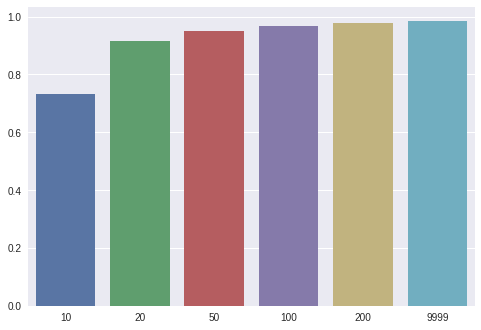

In [0]:
print(accs)
import seaborn as sns
sns.barplot(x=D,y=accs)



In [0]:
batch_size = 10
train_nn(Xinp,30,0.0003,"new")

<function relu at 0x7f48374d67b8>

<function relu at 0x7f48374d67b8>

<function relu at 0x7f48374d67b8>

<function relu at 0x7f48374d67b8>

<function relu at 0x7f48374d67b8>

None

[<tf.Variable 'U:0' shape=(784, 784) dtype=float32>, <tf.Variable 'V:0' shape=(784, 1024) dtype=float32>, <tf.Variable 'bias:0' shape=(1024,) dtype=float32>]
Epoch 0  out of  30  loss: 1466.4734708192027
accuracy: 0.97
Epoch 1  out of  30  loss: 749.9347237775177
accuracy: 0.98
Epoch 2  out of  30  loss: 618.6078517611861
accuracy: 0.98
Epoch 3  out of  30  loss: 549.5400302238461
accuracy: 0.98
Epoch 4  out of  30  loss: 518.1116290755598
accuracy: 0.98
Epoch 5  out of  30  loss: 496.20580851790146
accuracy: 0.98
Epoch 6  out of  30  loss: 479.72743784606155
accuracy: 0.98
Epoch 7  out of  30  loss: 452.32058644849167
accuracy: 0.98
Epoch 8  out of  30  loss: 448.622467947489
accuracy: 0.97
Epoch 9  out of  30  loss: 449.19941635737814
accuracy: 0.98
Epoch 10  out of  30  loss: 440.53655268212606
accuracy: 

In [0]:
a.shape,b.shape,c.shape

((1, 1024, 10), (1, 10), (1, 10, 10))